In [1]:
!nvidia-smi

Wed Nov 23 15:50:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 30%   25C    P8     4W / 250W |   6681MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 30%   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras import layers
from keras.layers import LeakyReLU, Dense, BatchNormalization

from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
# from tqdm.auto import tqdm
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 

pd.set_option('max_columns',100)

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(device)
# print(torch.cuda.device_count())

In [4]:
CONFIG = {
    'EPOCHS': 50,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':512,
    'SEED':101
}

In [5]:
random.seed(CONFIG['SEED'])
np.random.seed(CONFIG['SEED'])
tf.random.set_seed(CONFIG['SEED'])

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [7]:
def check_info(df):
    # show dataframe for each features that we have
    dataFeatures = []
    dataType     = []
    null         = []
    nullPCT      = []
    unique       = []
    minValue     = []
    maxValue     = []
    uniqueSample = []


    for item in list(df):
        dataFeatures.append(item)

    for item in dataFeatures:
        dataType.append(df[item].dtype.name)

    for item in dataFeatures:
        null.append(len(df[df[item].isnull() == True]))

    for item in dataFeatures:
        nullPCT.append(round(len(df[df[item].isnull() == True])/len(df[item])*100,2))

    for item in dataFeatures:
        minValue.append(df[item].min())

    for item in dataFeatures:
        maxValue.append(df[item].max())

    for item in dataFeatures:
        unique.append(df[item].nunique())

    for item in dataFeatures:
        uniqueSample.append(df[item].unique()[0:2])

    df_info = pd.DataFrame({
        'dataFeatures' : dataFeatures,
        'dataType' : dataType,
        'null' : null,
        'nullPCT':nullPCT,
        'unique' : unique,
        'minValue' : minValue,
        'maxValue' : maxValue,
        'uniqueSample':uniqueSample
    })
    
    return df_info

df_info = check_info(train)

In [8]:
percent20UP = list(df_info[df_info['nullPCT'] >= 20.0]['dataFeatures'])
percent20UP

['FH2O',
 'FNOX',
 'FOPTIMETHGLY',
 'FOXID',
 'FSO4',
 'FTBN',
 'FUEL',
 'SOOTPERCENTAGE',
 'U100',
 'U75',
 'U50',
 'U25',
 'U20',
 'U14',
 'U6',
 'U4',
 'V100']

In [9]:
# get dummies
dff = train.drop(percent20UP,axis=1)
dff = dff.fillna(0)
dff = pd.get_dummies(dff,columns=['COMPONENT_ARBITRARY'])


# data split
target = 'Y_LABEL'
features_for_model = [f for f in list(dff) if f not in [target,'ID']]

X = dff[features_for_model]
y = dff[target]

# data split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                 test_size=0.2, 
                                                 random_state=101)

In [10]:
X_train.shape

(11276, 38)

In [11]:
### 함수를 이용하여 모델 만들기
def create_baseline():
    model = tf.keras.Sequential()
    model.add(Dense(256,input_shape=[X_train.shape[1]], activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE'])
                  ,metrics=['accuracy'])
    return model

In [12]:
clf = KerasClassifier(build_fn=create_baseline, epochs=CONFIG['EPOCHS'], batch_size=CONFIG['BATCH_SIZE'], verbose=True)

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [14]:
history = clf.fit(X_train, y_train, epochs=CONFIG['EPOCHS'], batch_size=CONFIG['BATCH_SIZE'], validation_data=(X_test, y_test), callbacks=early_stop)

Epoch 1/50
23/23 [==============================] - 4s 27ms/step - loss: 0.7650 - accuracy: 0.6431 - val_loss: 0.9020 - val_accuracy: 0.3512
Epoch 2/50
23/23 [==============================] - 0s 11ms/step - loss: 0.4838 - accuracy: 0.8599 - val_loss: 0.3470 - val_accuracy: 0.9166
Epoch 3/50
23/23 [==============================] - 0s 20ms/step - loss: 0.3807 - accuracy: 0.9077 - val_loss: 0.3475 - val_accuracy: 0.9106
Epoch 4/50
23/23 [==============================] - 0s 15ms/step - loss: 0.3098 - accuracy: 0.9198 - val_loss: 0.3290 - val_accuracy: 0.9138
Epoch 5/50
23/23 [==============================] - 0s 12ms/step - loss: 0.2631 - accuracy: 0.9287 - val_loss: 0.2615 - val_accuracy: 0.9198
Epoch 6/50
23/23 [==============================] - 0s 10ms/step - loss: 0.2392 - accuracy: 0.9331 - val_loss: 0.2502 - val_accuracy: 0.9266
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 0.2286 - accuracy: 0.9323 - val_loss: 0.2660 - val_accuracy: 0.9273
Epoch 8/50
23/

In [15]:
history = history.history

(0.0, 100.0)

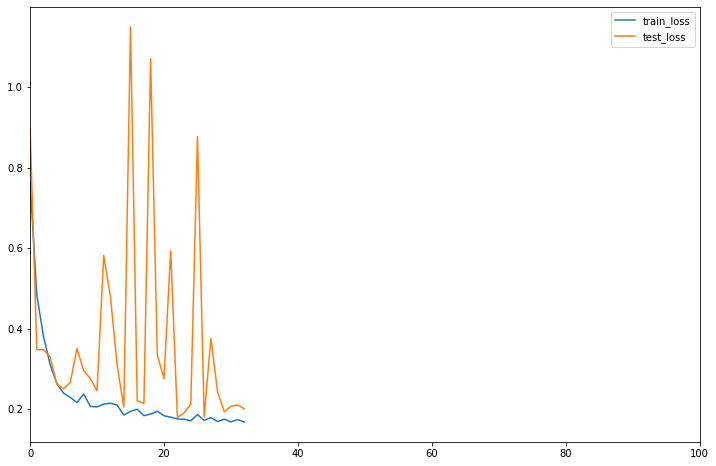

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(history['loss'], label = 'train_loss')
plt.plot(history['val_loss'], label = 'test_loss')
plt.legend()
plt.xlim(0,100)

In [17]:
clf.fit(X, y, epochs=CONFIG['EPOCHS'], batch_size=CONFIG['BATCH_SIZE'], callbacks=early_stop)

Epoch 1/50
28/28 [==============================] - 2s 8ms/step - loss: 0.6878 - accuracy: 0.7011
Epoch 2/50
28/28 [==============================] - 0s 8ms/step - loss: 0.4397 - accuracy: 0.9024
Epoch 3/50
28/28 [==============================] - 0s 9ms/step - loss: 0.3319 - accuracy: 0.9190
Epoch 4/50
28/28 [==============================] - 0s 7ms/step - loss: 0.2700 - accuracy: 0.9286
Epoch 5/50
28/28 [==============================] - 0s 8ms/step - loss: 0.2331 - accuracy: 0.9335
Epoch 6/50
28/28 [==============================] - 0s 7ms/step - loss: 0.2123 - accuracy: 0.9381
Epoch 7/50
28/28 [==============================] - 0s 7ms/step - loss: 0.2076 - accuracy: 0.9413
Epoch 8/50
28/28 [==============================] - 0s 7ms/step - loss: 0.1932 - accuracy: 0.9449
Epoch 9/50
28/28 [==============================] - 0s 8ms/step - loss: 0.1846 - accuracy: 0.9486
Epoch 10/50
28/28 [==============================] - 0s 7ms/step - loss: 0.1795 - accuracy: 0.9500
Epoch 11/50
28/28 [

28/28 [==============================] - 0s 8ms/step - loss: 0.1546 - accuracy: 0.9549
Epoch 28/50
28/28 [==============================] - 0s 8ms/step - loss: 0.1536 - accuracy: 0.9557
Epoch 29/50
28/28 [==============================] - 0s 7ms/step - loss: 0.1557 - accuracy: 0.9538
Epoch 30/50
28/28 [==============================] - 0s 7ms/step - loss: 0.1557 - accuracy: 0.9553
Epoch 31/50
28/28 [==============================] - 0s 7ms/step - loss: 0.1593 - accuracy: 0.9539
Epoch 32/50
28/28 [==============================] - 0s 8ms/step - loss: 0.1534 - accuracy: 0.9553
Epoch 33/50
28/28 [==============================] - 0s 9ms/step - loss: 0.1528 - accuracy: 0.9545
Epoch 34/50
28/28 [==============================] - 0s 9ms/step - loss: 0.1495 - accuracy: 0.9557
Epoch 35/50
28/28 [==============================] - 0s 8ms/step - loss: 0.1506 - accuracy: 0.9555
Epoch 36/50
28/28 [==============================] - 0s 8ms/step - loss: 0.1472 - accuracy: 0.9555
Epoch 37/50
28/28 [===

In [18]:
prediction_proba = clf.predict_proba(X)

In [19]:
X2 = X.copy()
y2 = y.copy()

X2['proba'] = prediction_proba[:,0]

In [20]:
dft = test[:]
dft = dft.fillna(0)
dft = pd.get_dummies(dft,columns=['COMPONENT_ARBITRARY']).drop('ID',axis=1)

In [21]:
list_test_cols = dft.columns

In [22]:
X2 = X2[list_test_cols]
y2 = y2

# data split
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, 
                                                 test_size=0.2, 
                                                 random_state=101)

In [23]:
X_train2.shape

(11276, 21)

In [24]:
### 함수를 이용하여 모델 만들기
def create_baseline2():
    model = tf.keras.Sequential()
    model.add(Dense(128,input_shape=[X_train2.shape[1]], activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE'])
                  ,metrics=['accuracy'])
    return model

In [25]:
rg = KerasRegressor(build_fn=create_baseline2, epochs=CONFIG['EPOCHS'], batch_size=CONFIG['BATCH_SIZE'], verbose=True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = rg.fit(X_train2, y_train2, epochs=CONFIG['EPOCHS'], batch_size=CONFIG['BATCH_SIZE'], validation_data=(X_test2, y_test2), callbacks=early_stop)

Epoch 1/50
23/23 [==============================] - 2s 23ms/step - loss: 0.6698 - accuracy: 0.6362 - val_loss: 0.8332 - val_accuracy: 0.6339
Epoch 2/50
23/23 [==============================] - 1s 24ms/step - loss: 0.5352 - accuracy: 0.8692 - val_loss: 0.5097 - val_accuracy: 0.7801
Epoch 3/50
23/23 [==============================] - 0s 17ms/step - loss: 0.4403 - accuracy: 0.9056 - val_loss: 0.4186 - val_accuracy: 0.9142
Epoch 4/50
23/23 [==============================] - 0s 15ms/step - loss: 0.3731 - accuracy: 0.9108 - val_loss: 0.3499 - val_accuracy: 0.9120
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 0.3269 - accuracy: 0.9144 - val_loss: 0.3244 - val_accuracy: 0.9117
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 0.3054 - accuracy: 0.9126 - val_loss: 0.2948 - val_accuracy: 0.9149
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.2909 - accuracy: 0.9138 - val_loss: 0.2926 - val_accuracy: 0.9131
Epoch 8/50
23/2

In [26]:
rg.fit(X2, y2, epochs=CONFIG['EPOCHS'], batch_size=CONFIG['BATCH_SIZE'], callbacks=early_stop)

Epoch 1/50
28/28 [==============================] - 1s 6ms/step - loss: 0.6483 - accuracy: 0.6917
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 0.4916 - accuracy: 0.8966
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 0.3951 - accuracy: 0.9093
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 0.3325 - accuracy: 0.9127
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 0.3027 - accuracy: 0.9142
Epoch 6/50
28/28 [==============================] - 0s 5ms/step - loss: 0.2893 - accuracy: 0.9142
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 0.2850 - accuracy: 0.9146
Epoch 8/50
28/28 [==============================] - 0s 5ms/step - loss: 0.2819 - accuracy: 0.9147
Epoch 9/50
28/28 [==============================] - 0s 5ms/step - loss: 0.2813 - accuracy: 0.9145
Epoch 10/50
28/28 [==============================] - 0s 5ms/step - loss: 0.2811 - accuracy: 0.9151
Epoch 11/50
28/28 [

28/28 [==============================] - 0s 6ms/step - loss: 0.2753 - accuracy: 0.9156
Epoch 28/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2759 - accuracy: 0.9151
Epoch 29/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2744 - accuracy: 0.9151
Epoch 30/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2758 - accuracy: 0.9151
Epoch 31/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2734 - accuracy: 0.9154
Epoch 32/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2746 - accuracy: 0.9156
Epoch 33/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2730 - accuracy: 0.9156
Epoch 34/50
28/28 [==============================] - 0s 7ms/step - loss: 0.2728 - accuracy: 0.9156
Epoch 35/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2724 - accuracy: 0.9156
Epoch 36/50
28/28 [==============================] - 0s 5ms/step - loss: 0.2737 - accuracy: 0.9156
Epoch 37/50
28/28 [===

In [27]:
prediction_proba2 = rg.predict(X2)

28/28 [==============================] - 0s 2ms/step


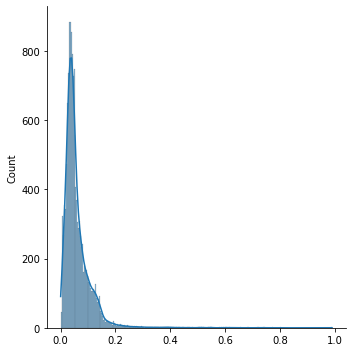

In [70]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (12,9)
sns.displot(prediction_proba2,kde=True)

In [92]:
threshold = 0.15
pred_labels = np.where(np.array(prediction_proba2) > threshold, 1, 0)

In [93]:
len(prediction_proba2[pred_labels==1])

507

In [94]:
len(prediction_proba2[pred_labels==0])

13588

In [95]:
print(classification_report(y,pred_labels))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     12892
           1       0.32      0.14      0.19      1203

    accuracy                           0.90     14095
   macro avg       0.62      0.55      0.57     14095
weighted avg       0.87      0.90      0.88     14095



In [96]:
result = rg.predict(dft)

12/12 [==============================] - 0s 2ms/step


In [97]:
result_labels = np.where(np.array(result) > threshold, 1, 0)

In [98]:
submit = pd.read_csv('data/sample_submission.csv')
submit['Y_LABEL'] = result_labels
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [99]:
submit[submit['Y_LABEL']==0]

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
6035,TEST_6035,0
6036,TEST_6036,0
6037,TEST_6037,0
6039,TEST_6039,0


In [100]:
submit[submit['Y_LABEL']==1]

,ID,Y_LABEL
5,TEST_0005,1
8,TEST_0008,1
16,TEST_0016,1
32,TEST_0032,1
45,TEST_0045,1
...,...,...
5884,TEST_5884,1
5942,TEST_5942,1
5961,TEST_5961,1
5996,TEST_5996,1
